# Loading and preparing Dataset

In [1]:

!pip install ultralytics tensorflow kagglehub


In [2]:

import kagglehub
from pathlib import Path

# Download the "Colour Classification" dataset
path = kagglehub.dataset_download("trushraut18/colour-classification")
data_dir = Path(path)

print("Data directory:", data_dir)


Data directory: /Users/mohammad/.cache/kagglehub/datasets/trushraut18/colour-classification/versions/1


In [4]:

import kagglehub
from pathlib import Path

# 1) Download the dataset
path = kagglehub.dataset_download("trushraut18/colour-classification")

data_dir = Path(path)
if (data_dir / "Data").is_dir():
    data_dir = data_dir / "Data"

print("Data directory:", data_dir)


Data directory: /Users/mohammad/.cache/kagglehub/datasets/trushraut18/colour-classification/versions/1/Data


In [5]:

import os
import shutil
from pathlib import Path

# Create YOLO-compatible directory structure
yolo_dir = Path("yolo_dataset")
if yolo_dir.exists():
    shutil.rmtree(yolo_dir)

# Create directories
for split in ["train", "val"]:
    (yolo_dir / split / "images").mkdir(parents=True, exist_ok=True)
    (yolo_dir / split / "labels").mkdir(parents=True, exist_ok=True)

# Define class mapping
class_names = ["Blue", "Green", "Red"]
class_to_id = {name: i for i, name in enumerate(class_names)}
print("Classes:", class_names)

# Copy and prepare data for YOLO format
for split in ["train", "validation"]:
    yolo_split = "val" if split == "validation" else "train"

    # Process each class
    for class_name in class_names:
        class_dir = data_dir / split / class_name
        class_id = class_to_id[class_name]

        # Process each image
        for img_path in class_dir.glob("*.jpg"):
            # Copy image to YOLO directory
            dest_img = yolo_dir / yolo_split / "images" / img_path.name
            shutil.copy(img_path, dest_img)

            # Create corresponding label file (center point with full width/height)
            # YOLO format: <class_id> <x_center> <y_center> <width> <height>
            # For color classification, we'll use the entire image
            label_content = f"{class_id} 0.5 0.5 1.0 1.0"

            label_path = yolo_dir / yolo_split / "labels" / (img_path.stem + ".txt")
            with open(label_path, "w") as f:
                f.write(label_content)

print(f"YOLO dataset prepared at {yolo_dir}")


Classes: ['Blue', 'Green', 'Red']
YOLO dataset prepared at yolo_dataset


In [6]:

# Create YAML configuration file for YOLO
yaml_content = f'''
path: {os.getcwd()}/yolo_dataset
train: train/images
val: val/images

# Classes
names:
  0: Blue
  1: Green
  2: Red
'''

with open("color_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("Created YAML configuration file: color_dataset.yaml")


Created YAML configuration file: color_dataset.yaml


# Training the model

In [7]:

from ultralytics import YOLO

model = YOLO('yolov8n.pt')  

results = model.train(
    data='color_dataset.yaml',
    epochs=10,
    imgsz=260,
    batch=8,
    patience=5
)

print("Training completed!")


100%|██████████| 6.25M/6.25M [00:00<00:00, 8.93MB/s]


Ultralytics 8.3.119 🚀 Python-3.12.2 torch-2.7.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=color_dataset.yaml, epochs=10, time=None, patience=5, batch=8, imgsz=260, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras

train: Scanning /Users/mohammad/Downloads/yolo_dataset/train/labels... 2699 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2700/2700 [00:00<00:00, 4062.10it/s]

train: /Users/mohammad/Downloads/yolo_dataset/train/images/Red721.jpg: ignoring corrupt image/label: image file is truncated (55 bytes not processed)
train: New cache created: /Users/mohammad/Downloads/yolo_dataset/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 315.8±259.7 MB/s, size: 133.6 KB)


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/mohammad/Downloads/yolo_dataset/val/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 3202.88it/s]

val: New cache created: /Users/mohammad/Downloads/yolo_dataset/val/labels.cache



/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 288 train, 288 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G     0.2339      1.158     0.8985          3        288: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]

                   all        300        300      0.724      0.925      0.959      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.1988     0.4945     0.8802          3        288: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]

                   all        300        300      0.923      0.935      0.968      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.1917       0.35     0.8732          3        288: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]

                   all        300        300      0.955      0.916      0.951      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.1641     0.2964     0.8657          3        288: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]

                   all        300        300      0.941      0.955      0.971      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.1388     0.2292     0.8637          3        288: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]

                   all        300        300      0.965      0.985      0.988      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      0.124     0.2099     0.8598          3        288: 100%|██████████| 338/338 [01:36<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]

                   all        300        300      0.976      0.991      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G    0.09857     0.1531     0.8554          3        288: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]

                   all        300        300      0.983      0.993      0.989      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G    0.08263     0.1302     0.8592          3        288: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]

                   all        300        300      0.995      0.993      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G    0.07208     0.1203     0.8471          3        288: 100%|██████████| 338/338 [01:39<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]

                   all        300        300      0.983      0.987      0.989      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G    0.06116     0.0982      0.858          3        288: 100%|██████████| 338/338 [01:40<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]

                   all        300        300      0.988       0.99       0.99      0.989



10 epochs completed in 0.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.2 torch-2.7.0 CPU (Apple M2)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


                   all        300        300      0.995      0.993      0.993      0.992
                  Blue        100        100      0.988          1      0.991      0.991
                 Green        100        100      0.997       0.98      0.993      0.989
                   Red        100        100      0.999          1      0.995      0.995
Speed: 0.1ms preprocess, 29.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train
Training completed!


# Validation

In [26]:
val_results = model.val()
print(f"Validation results: {val_results}")


Ultralytics 8.3.119 🚀 Python-3.12.2 torch-2.7.0 CPU (Apple M2)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 111.5±82.3 MB/s, size: 32.0 KB)


val: Scanning /Users/mohammad/Downloads/yolo_dataset/val/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00,  9.70it/s]


                   all        300        300      0.984      0.993      0.992      0.987
                  Blue        100        100      0.971          1      0.989      0.983
                 Green        100        100       0.99       0.98      0.992      0.984
                   Red        100        100      0.991          1      0.995      0.995
Speed: 0.1ms preprocess, 11.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train3
Validation results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x30e94f350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.01101

# Results of Train

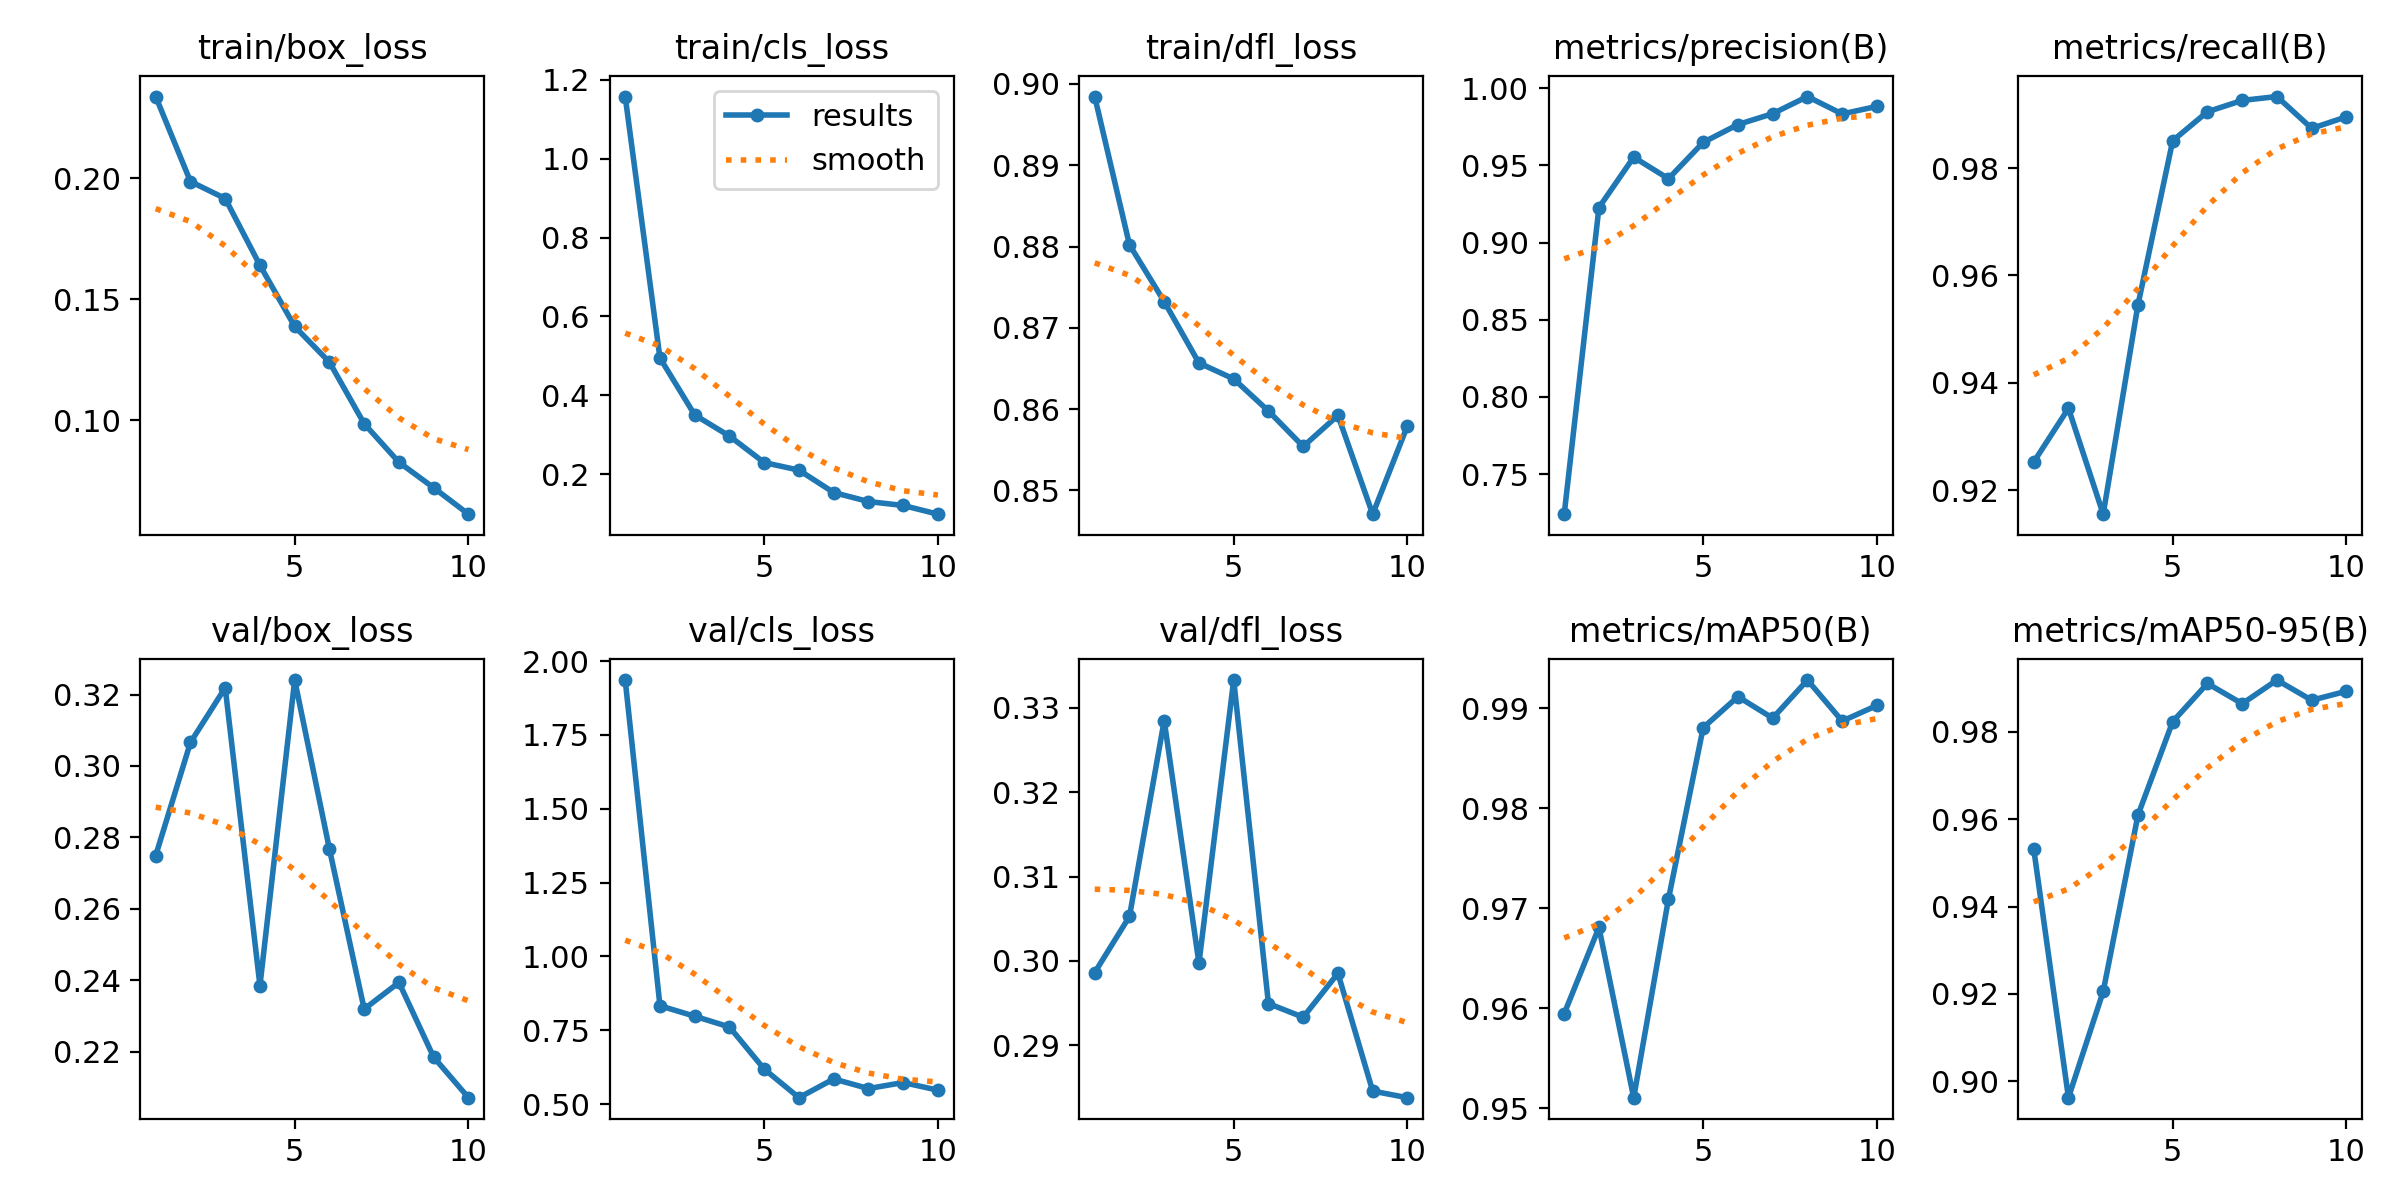

In [27]:
from IPython.display import Image, display

# Use a relative path to the notebook
display(Image(filename='/Users/mohammad/Downloads/runs/detect/train/results.png'))

# Confusion Matrix

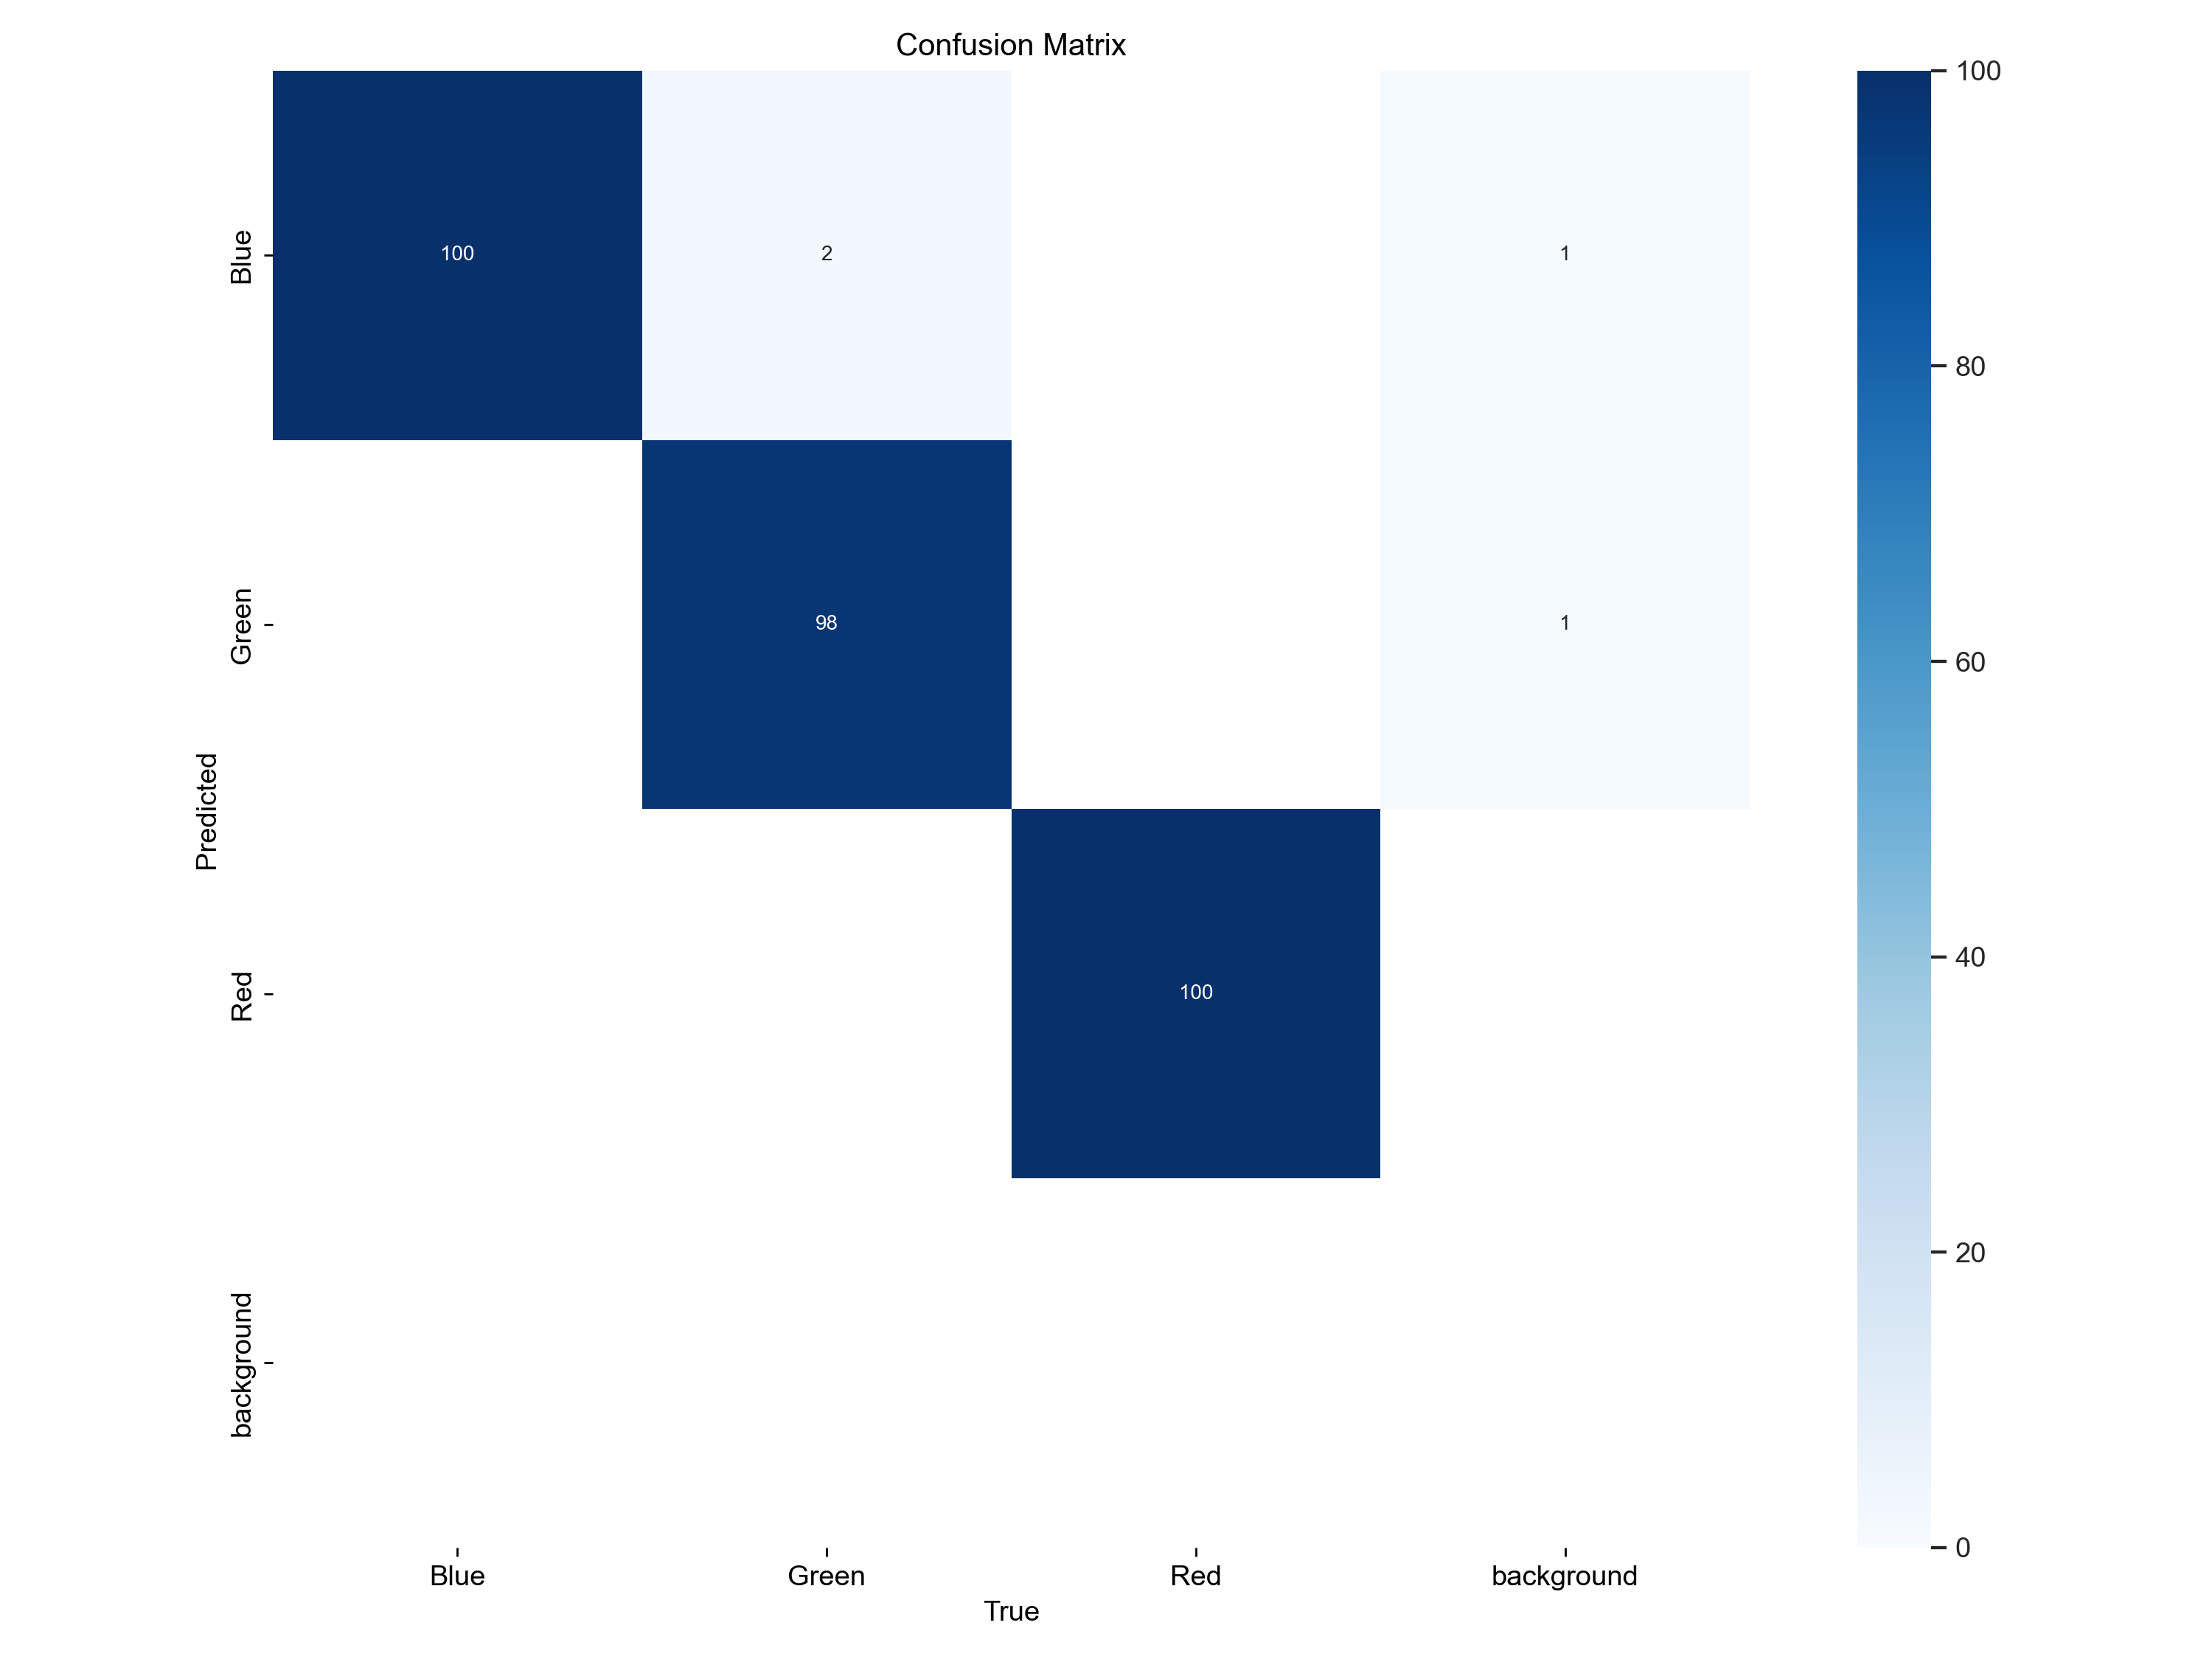

In [1]:
from IPython.display import Image, display

display(Image(filename='/Users/mohammad/Downloads/runs/detect/train/confusion_matrix.png'))

# Testing

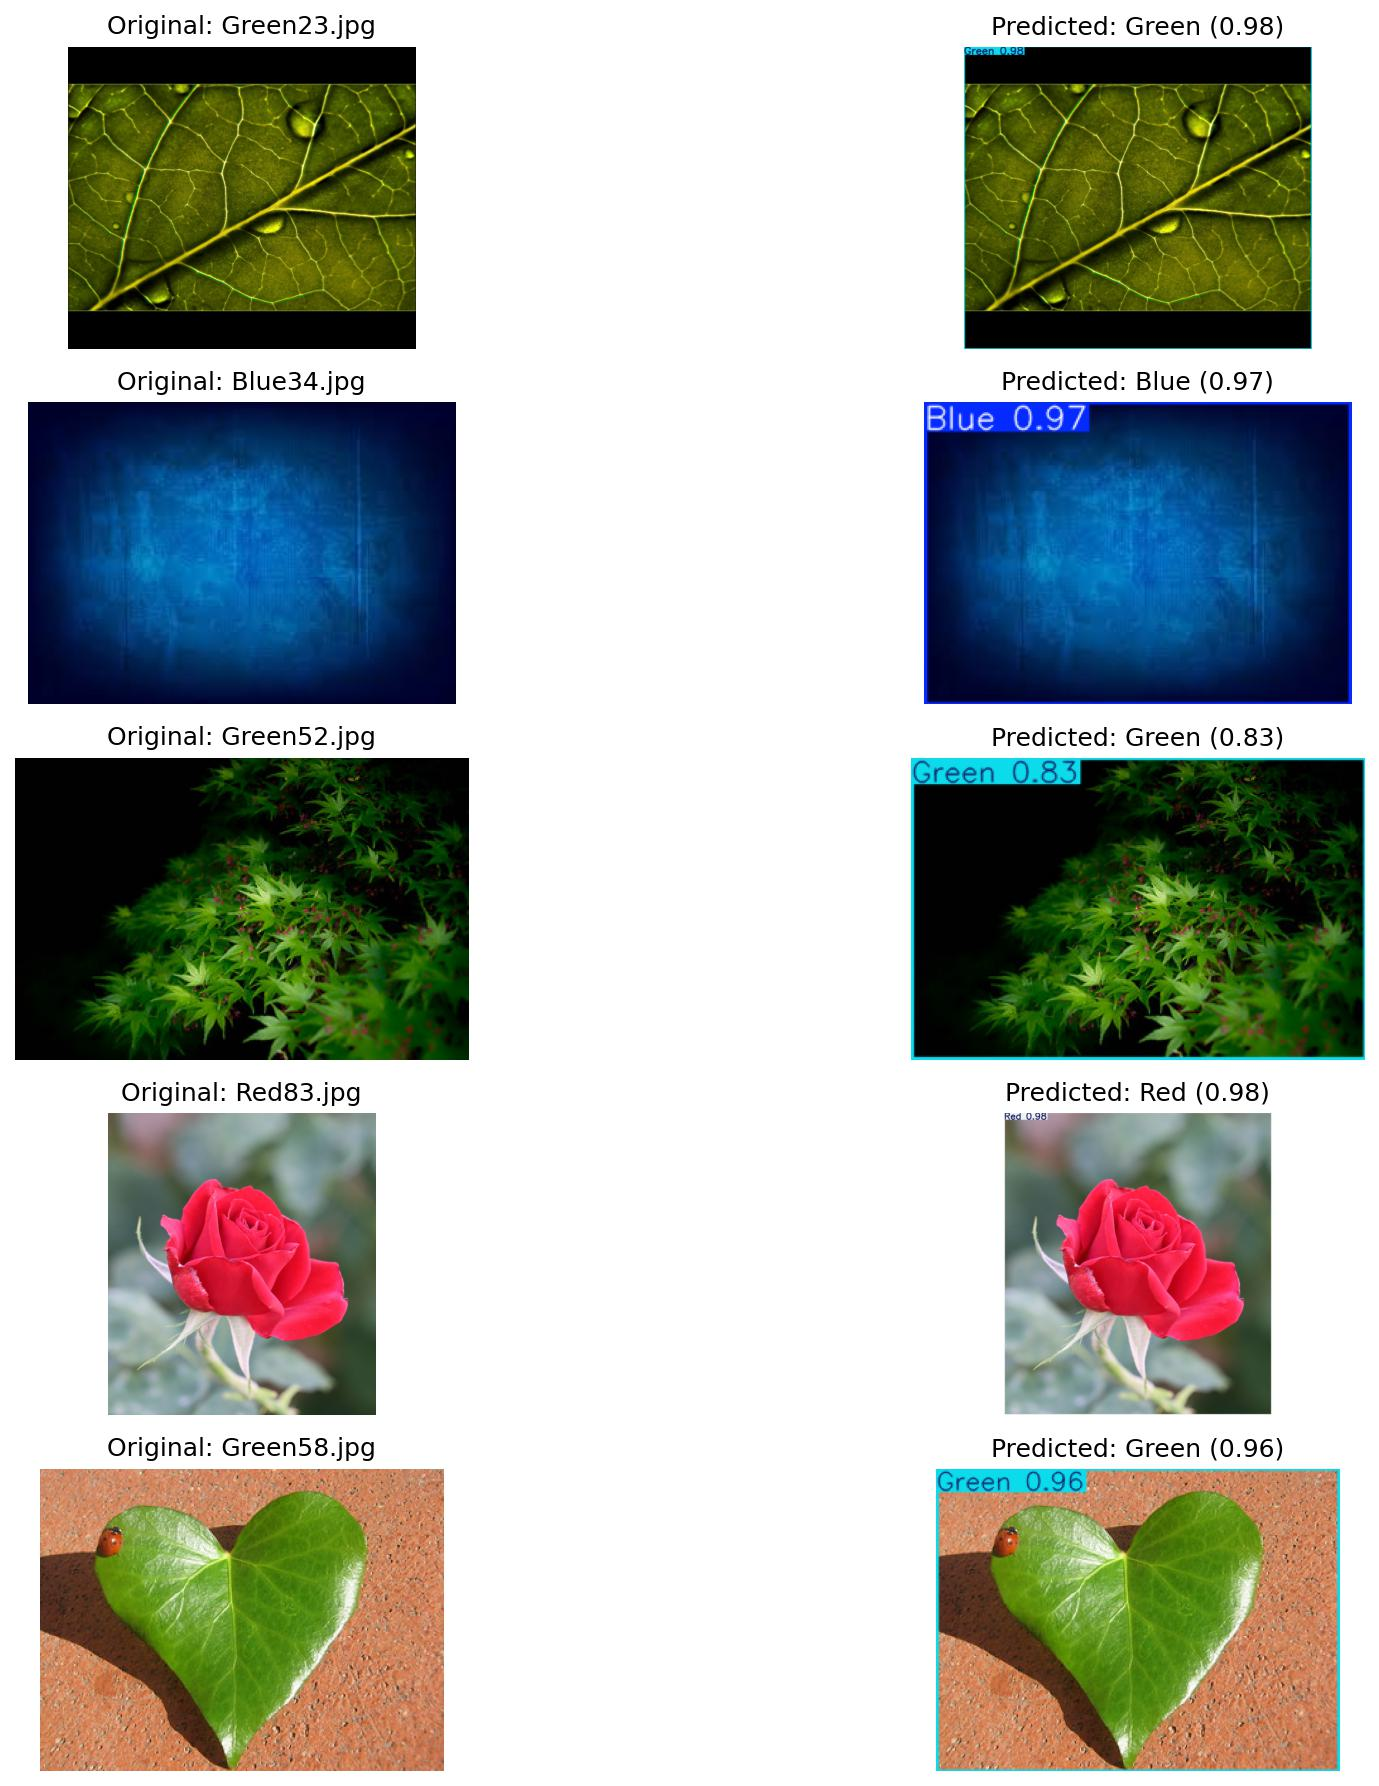

In [4]:
from IPython.display import Image, display

display(Image(filename='color_detection_results.jpg', width=500))

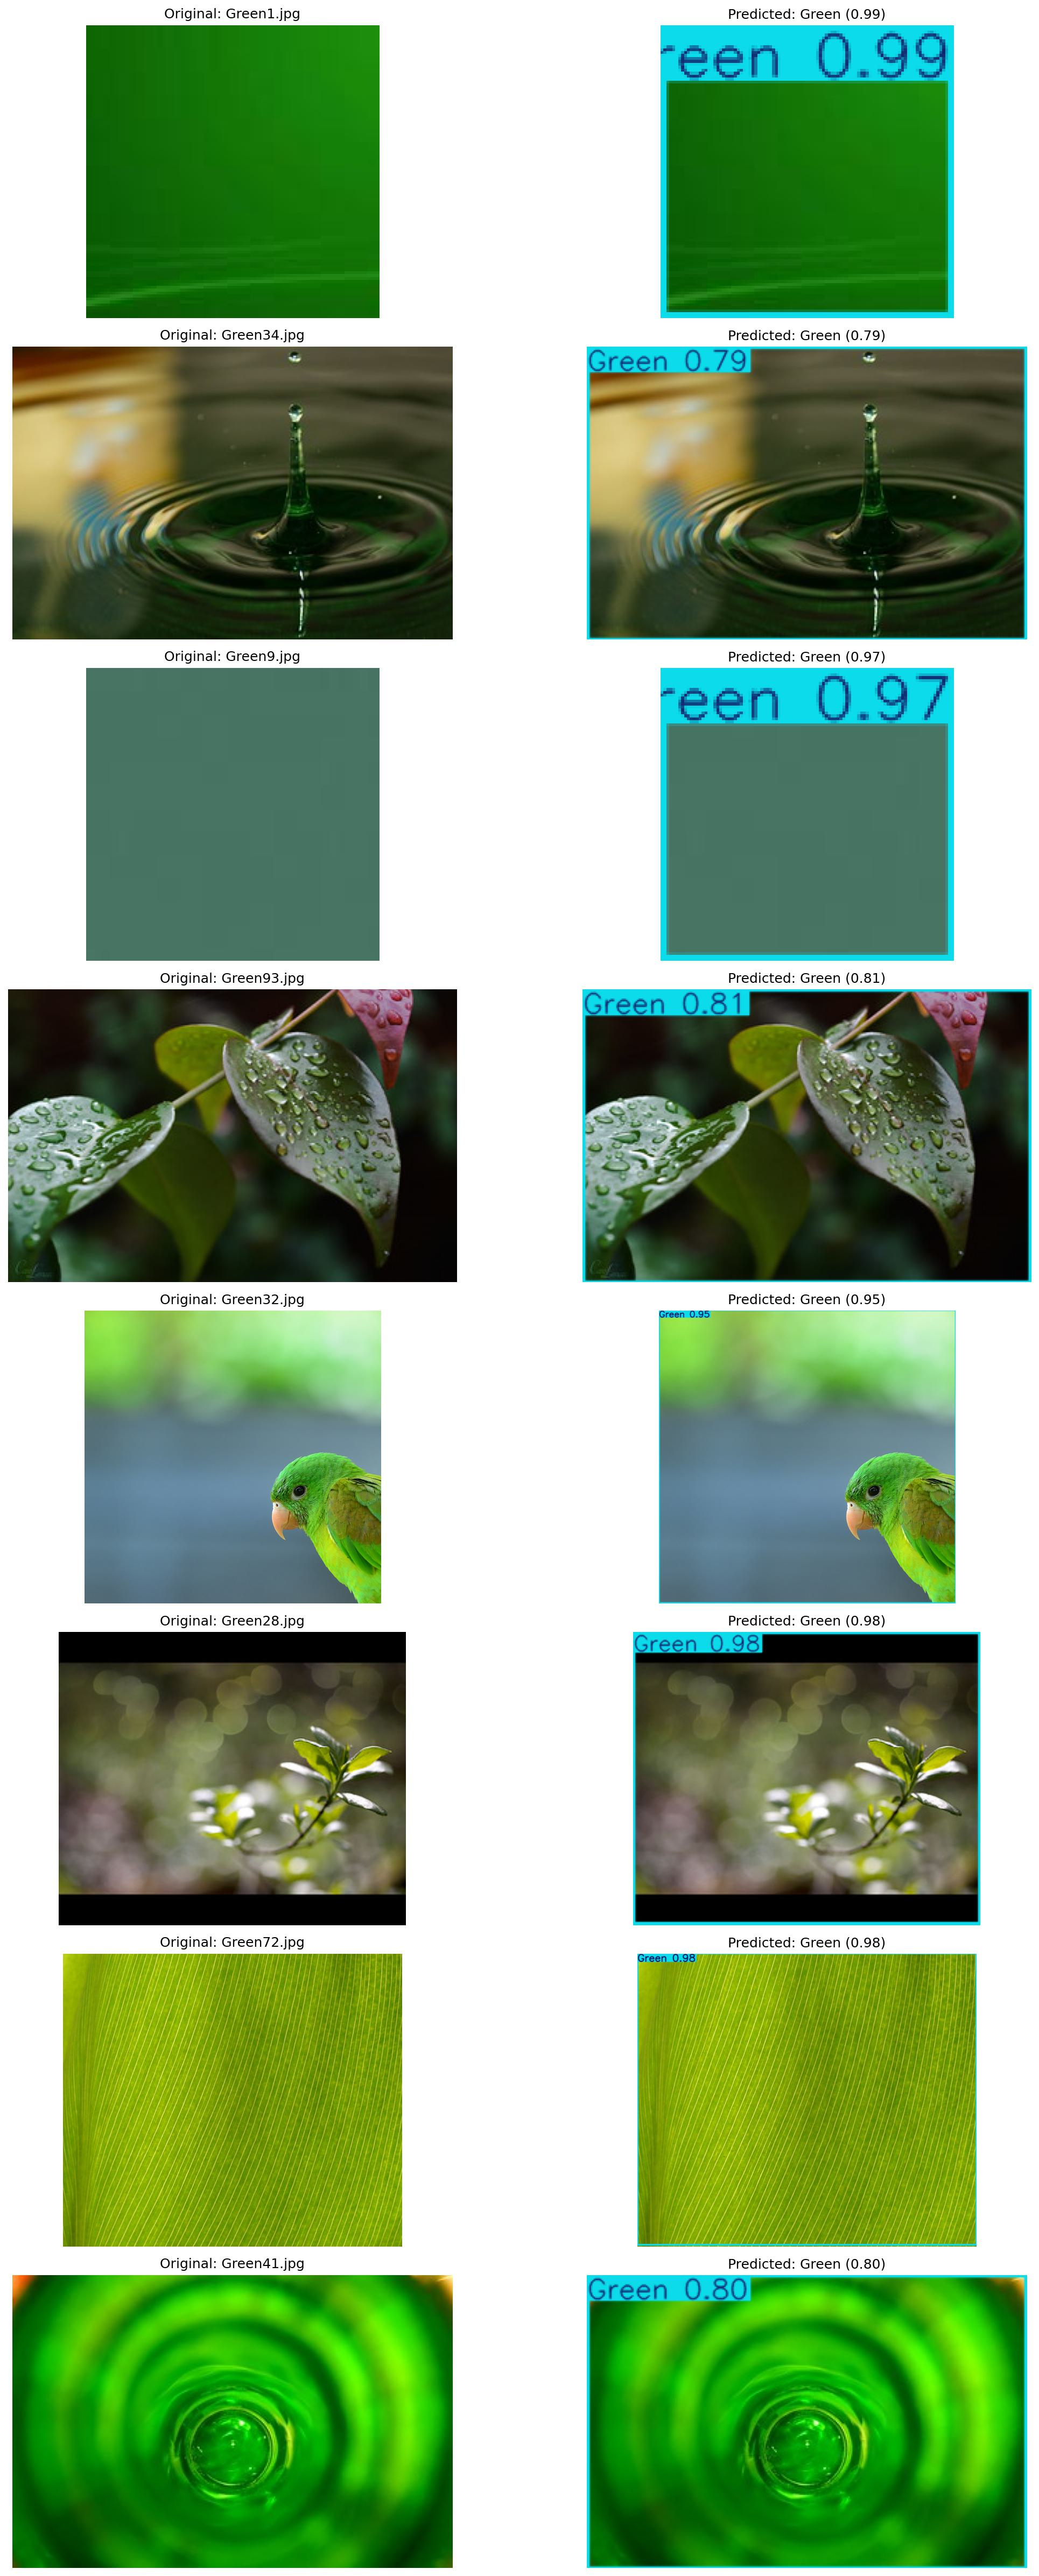

In [37]:
from IPython.display import Image, display

display(Image(filename='/Users/mohammad/Downloads/green_detection_results.jpg', width=500))

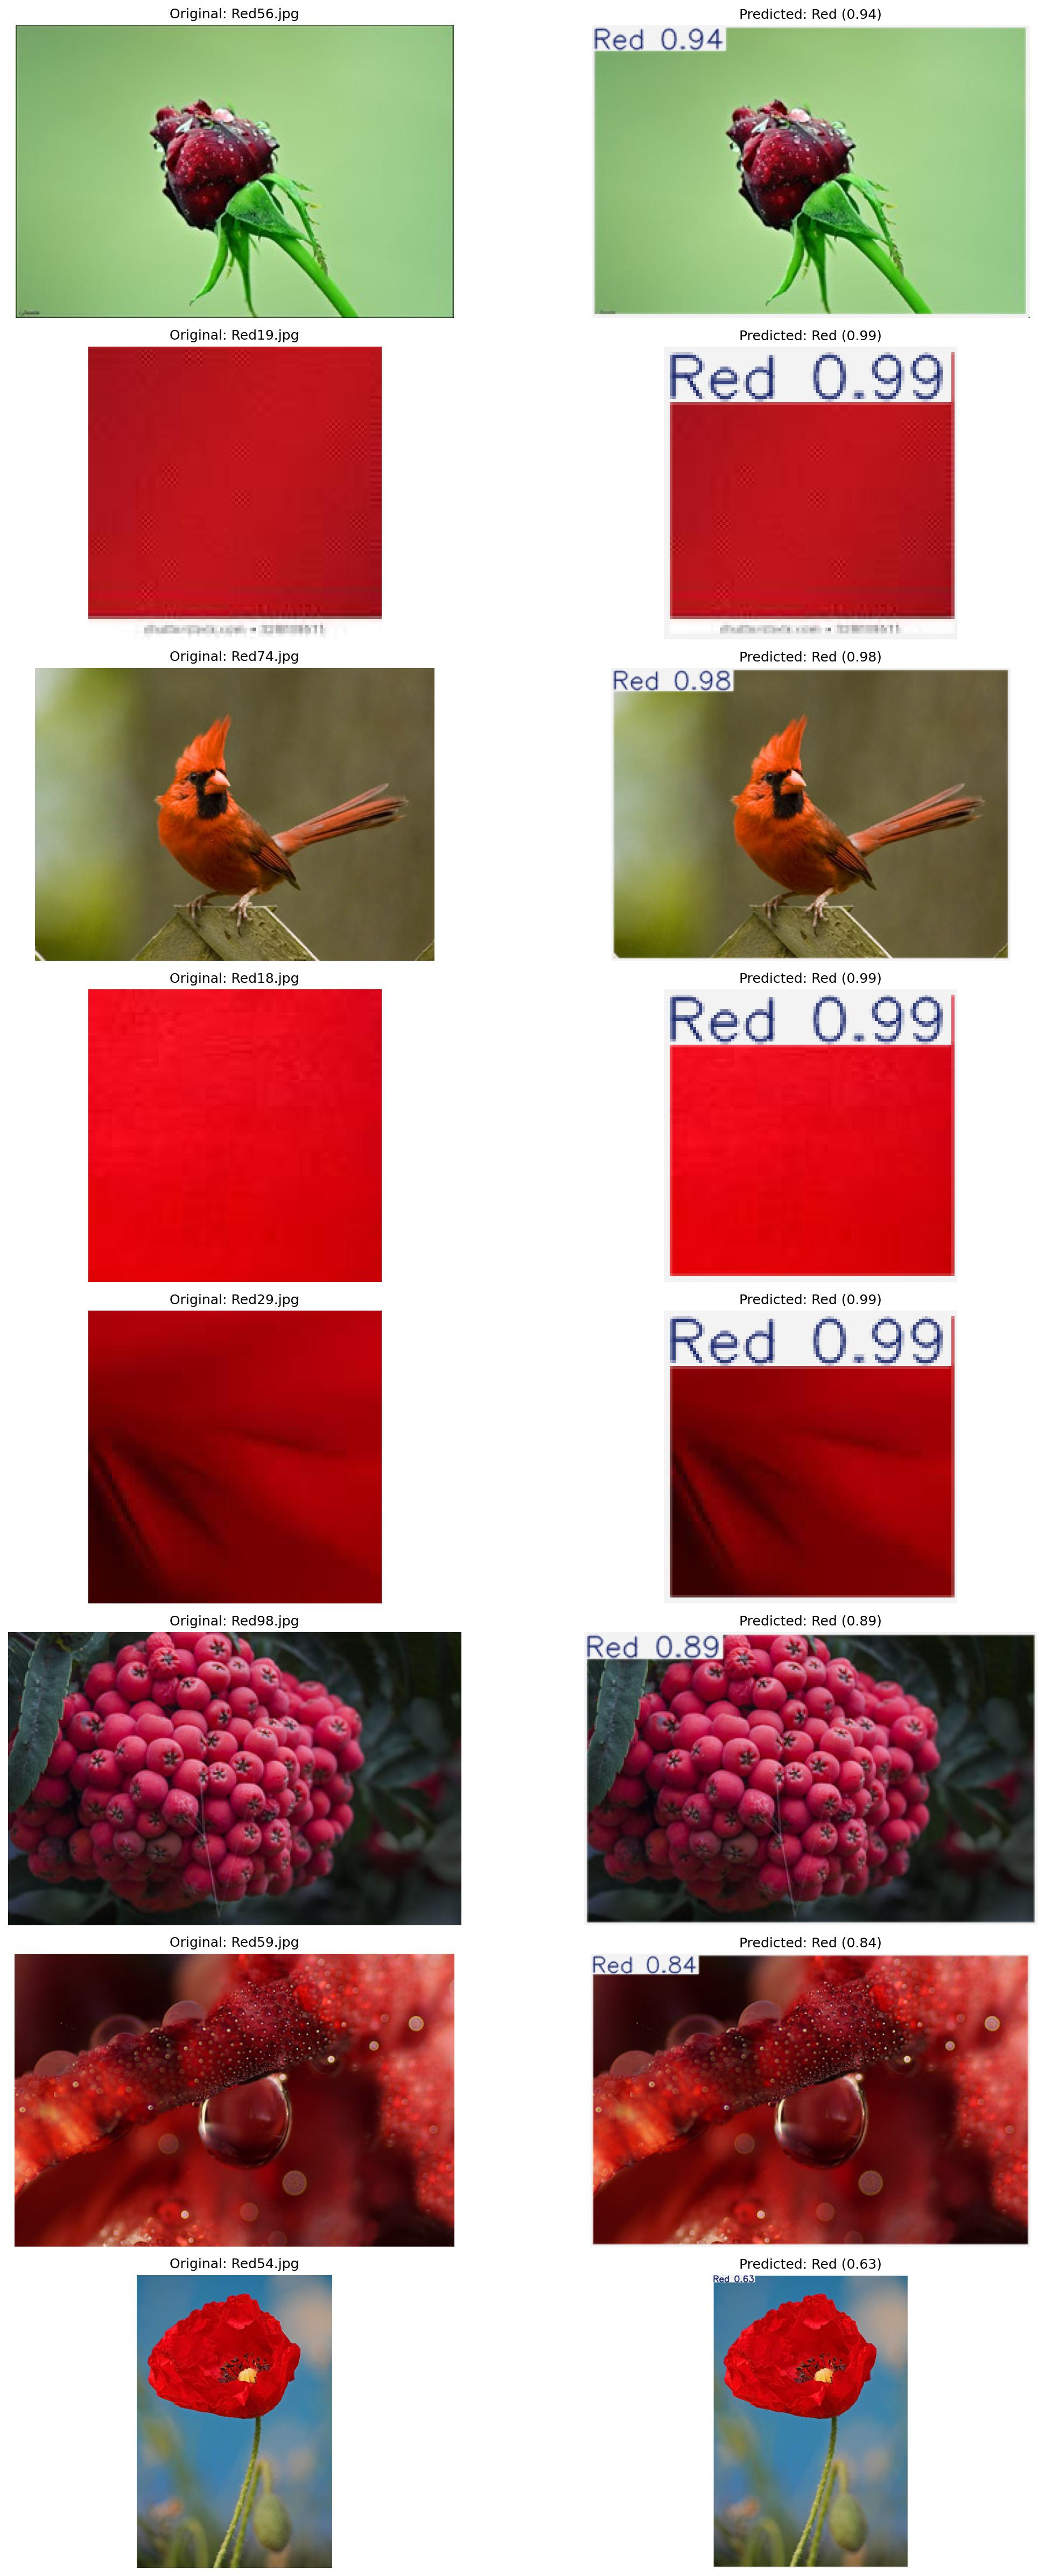

In [38]:
from IPython.display import Image, display

display(Image(filename='/Users/mohammad/Downloads/red_detection_results.jpg', width=500))

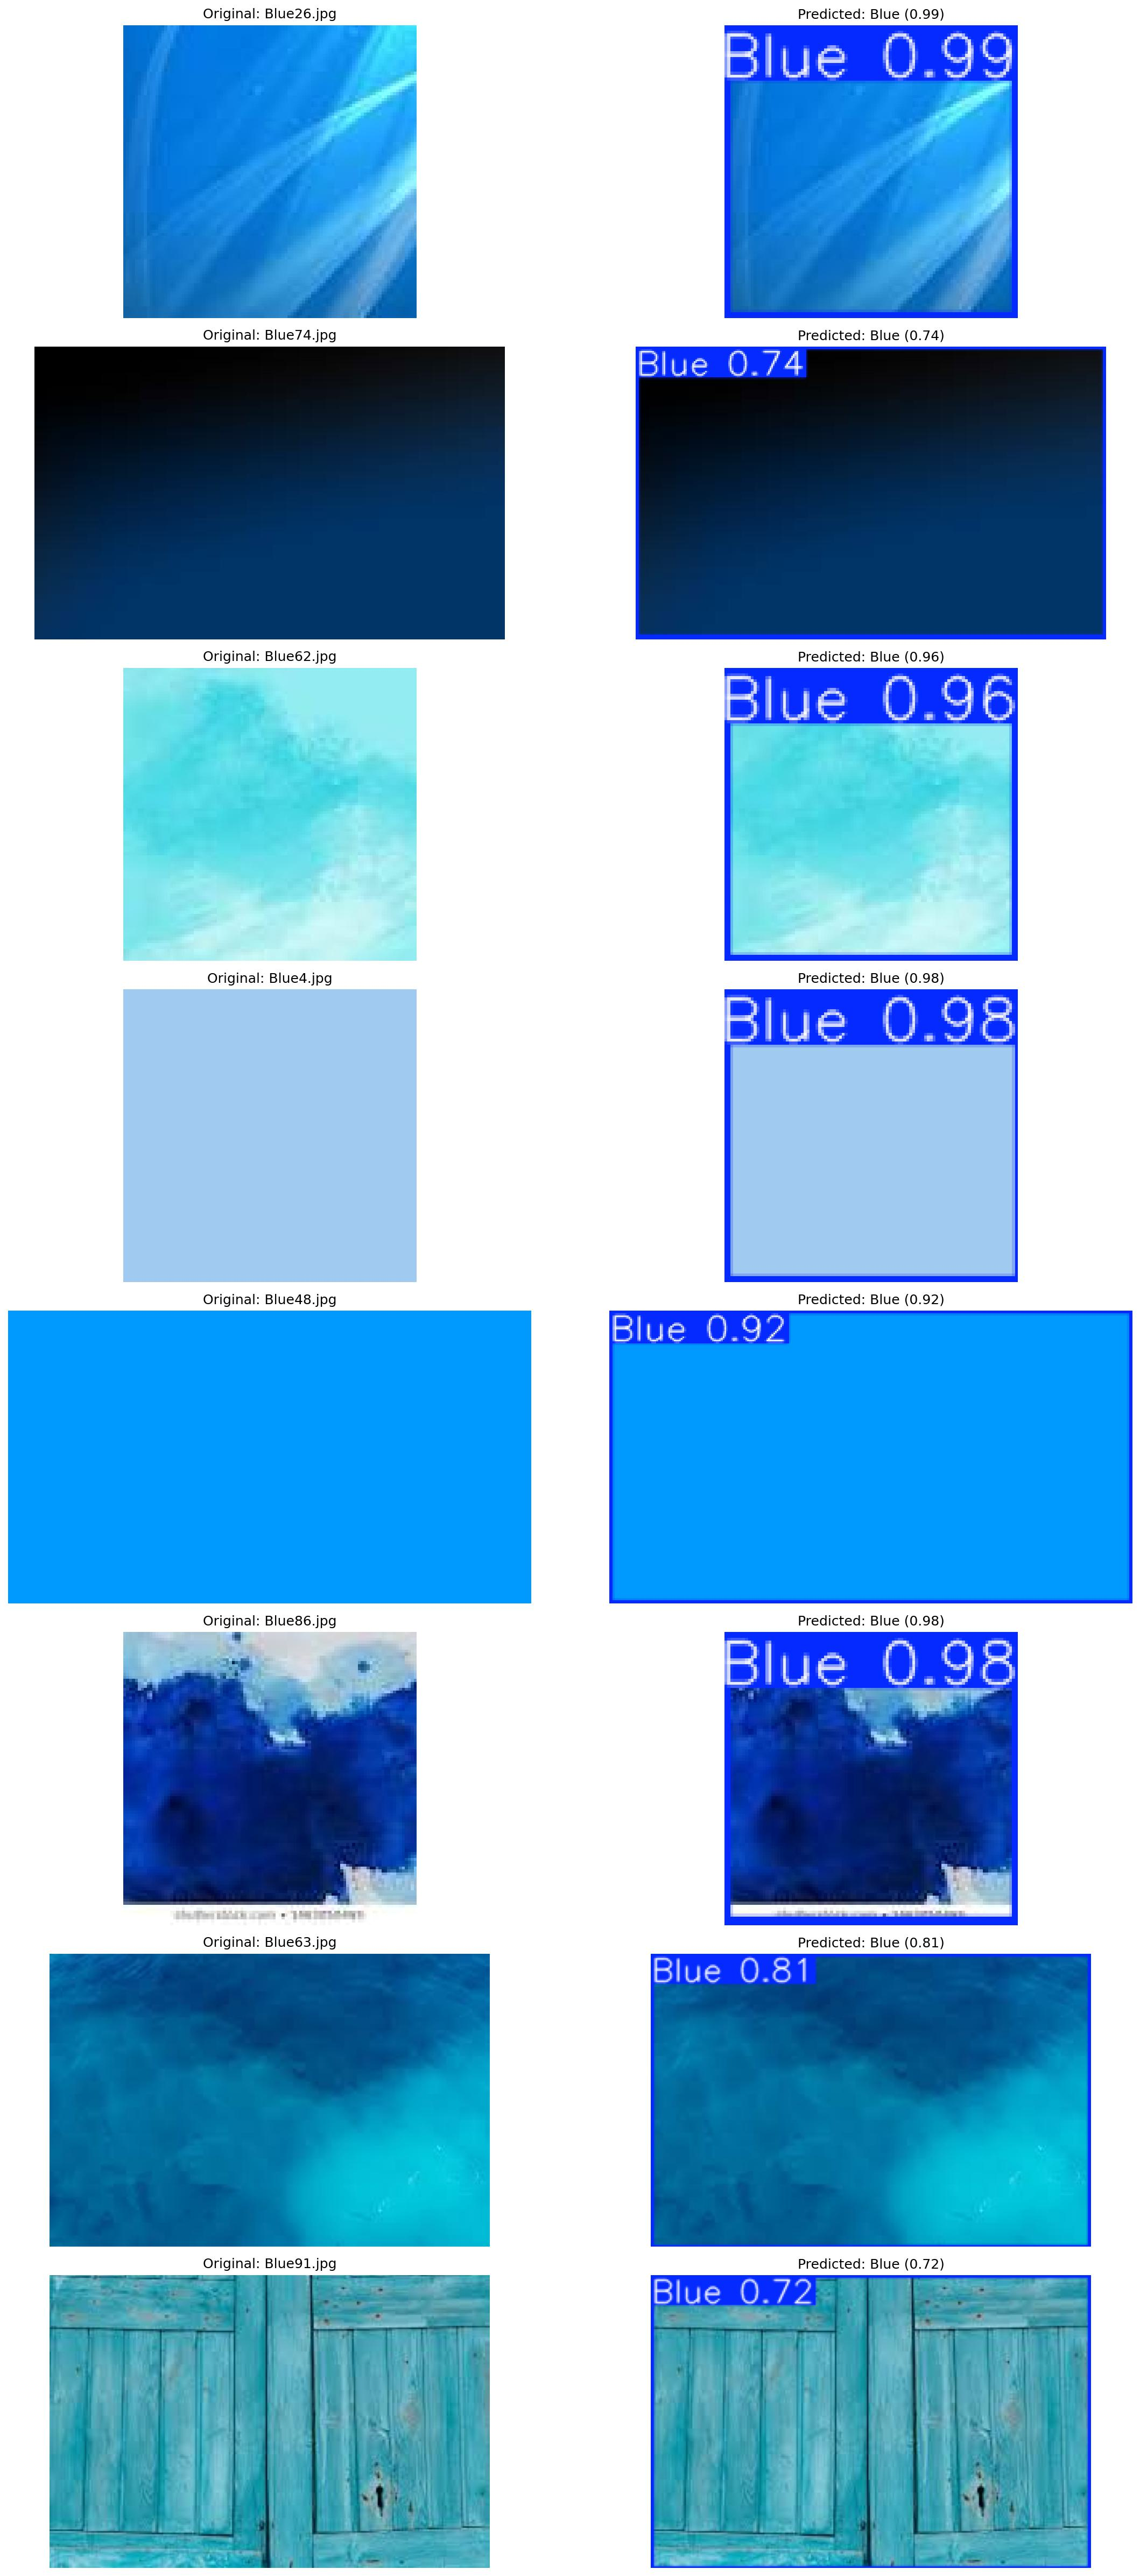

In [3]:
from IPython.display import Image, display

display(Image(filename='/Users/mohammad/Downloads/Blue_detection_results.jpg', width=500))